In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from torch.utils.data.dataset import Dataset
import pandas as pd
import torch
import ast
from torchvision.io import read_image
import os

In [ ]:
import cv2
import numpy as np

In [ ]:
csv_path = "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/Dataset/dataset_pr.csv"
img_path = "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/Dataset/Images"

In [ ]:
with tf.device('/cpu:0'):
  class CoinDataset(Dataset):
    """Euro Coin dataset."""

    def __init__(self, csv_file, root_dir, width, height,transforms=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.coin_frame = pd.read_csv(csv_file, header = None)
        print("Dataset caricato correttamente numero immagini:",len(self.coin_frame))
        self.root_dir = root_dir
        self.transforms = transforms
        self.height = height
        self.width = width
        self.classes = [_, '10_cent']

    def getClass(self):
      return len(self.classes)

    def __len__(self):
        return len(self.coin_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.coin_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        label = torch.tensor(ast.literal_eval(self.coin_frame.iloc[idx, 1]), dtype=torch.float32)
        box = torch.tensor(ast.literal_eval(self.coin_frame.iloc[idx, 2])).unsqueeze(0)
        box /= 150

        sample = {'image': image, 'label': label, 'box' : box}

        area = (box[:, 3] - box[:, 1]) * (box[:, 2] - box[:, 0])
        iscrowd = torch.zeros((box.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = sample['box']
        target['labels'] =  sample['label']
        target['area'] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([idx])

        if self.transforms:

              sample = self.transforms(image = img_res,
                                      bboxes = target['boxes'],
                                      labels = sample['label'])

              img_res = sample['image']
              target['boxes'] = torch.Tensor(sample['bboxes'])



        return img_res, target

  dataset = CoinDataset(csv_path, img_path, 150 ,150)


Dataset caricato correttamente numero immagini: 600


In [ ]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import cv2

from xml.etree import ElementTree as et

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

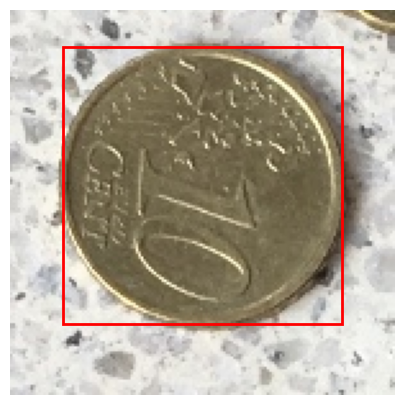

In [ ]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)
    a.axis('off')
    plt.show()

img, target = dataset[25]
plot_img_bbox(img, target)

# Model

In [ ]:
def get_object_detection_model(num_classes):


    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
dataset =  CoinDataset(csv_path, img_path, 150, 150, transforms= get_transform(train=True))
dataset_test =  CoinDataset(csv_path, img_path, 150, 150, transforms= get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Dataset caricato correttamente numero immagini: 600
Dataset caricato correttamente numero immagini: 600


# Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

model = get_object_detection_model(num_classes)

model.to('cuda:0')

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
print(model.state_dict)

<bound method Module.state_dict of FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2):

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

# Salvataggio del modello e dei pesi

In [ ]:
path_model =  "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/CheckPoint/faster_rcnn_ligth.onnx"

In [ ]:
!pip install onnx

In [ ]:
import onnx
input = torch.randn(1, 3, 150, 150)
print(input.shape)
torch.onnx.export(model, input.cuda(), path_model, export_params=True, opset_version = 17, input_names = ['image'], output_names = ['boxes', 'labels', 'scores'])
